# Recreating NeRF
This is a PyTorch implementation based on the paper: https://arxiv.org/abs/2003.08934. The code takes mostly after the officially tiny nerf implementation: https://colab.research.google.com/github/bmild/nerf/blob/master/tiny_nerf.ipynb

In [ ]:
!pip install numpy tqdm ipywidgets matplotlib
!pip3 install torch torchvision torchaudio
!pip install imageio
!pip install python-ffmpeg
!pip install imageio-ffmpeg

## Imports + Data


In [20]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.init as init
import time
import numpy as np
import torch.nn.functional as F
import os
from tqdm import tqdm
from ipywidgets import interactive, widgets

#Example data http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

## Encoding + Model

$$\gamma(p) = (\sin(2^0\pi p), \cos(2^0\pi p), \dots, \sin(2^{L-1}\pi p), \cos(2^{L-1}\pi p))$$

In [21]:
def encoding(x, L=10):
    rets = [x]
    for i in range(L):
        for fn in [torch.sin, torch.cos]:  # Use torch functions
            rets.append(fn(2. ** i * x))
    return torch.cat(rets, dim=-1)  # Concatenate along the last dimension

class NeRF(nn.Module):

  def __init__(self, pos_enc_dim = 63, view_enc_dim = 27, hidden = 256) -> None:
     super().__init__()

     self.linear1 = nn.Sequential(nn.Linear(pos_enc_dim,hidden),nn.ReLU())

     self.pre_skip_linear = nn.Sequential()
     for _ in range(4):
      self.pre_skip_linear.append(nn.Linear(hidden,hidden))
      self.pre_skip_linear.append(nn.ReLU())


     self.linear_skip = nn.Sequential(nn.Linear(hidden+pos_enc_dim,hidden),nn.ReLU())

     self.post_skip_linear = nn.Sequential()
     for _ in range(2):
      self.post_skip_linear.append(nn.Linear(hidden,hidden))
      self.post_skip_linear.append(nn.ReLU())

     self.density_layer = nn.Sequential(nn.Linear(hidden,1), nn.ReLU())

     self.linear2 = nn.Linear(hidden,hidden)

     self.color_linear1 = nn.Sequential(nn.Linear(hidden+view_enc_dim,hidden//2),nn.ReLU())
     self.color_linear2 = nn.Sequential(nn.Linear(hidden//2, 3),nn.Sigmoid())

     self.relu = nn.ReLU()
     self.sigmoid = nn.Sigmoid()


  def forward(self,input):

    # Extract pos and view dirs
    positions = input[..., :3]
    view_dirs = input[...,3:]

    # Encode
    pos_enc = encoding(positions,L=10)
    view_enc = encoding(view_dirs, L=4)

    x = self.linear1(pos_enc)
    x = self.pre_skip_linear(x)

    # Skip connection
    x = torch.cat([x, pos_enc], dim=-1)
    x = self.linear_skip(x)

    x = self.post_skip_linear(x)

    # Density prediction
    sigma = self.density_layer(x)

    x = self.linear2(x)

    # Incoroporate view encoding
    x = torch.cat([x, view_enc],dim=-1)
    x = self.color_linear1(x)

    # Color Prediction
    rgb = self.color_linear2(x)

    return torch.cat([sigma, rgb], dim=-1) 

## Get Ray + Render

In [30]:
def get_rays(H, W, focal, c2w):
    """
    Generate rays for a given camera configuration.

    Args:
      H: Image height.
      W: Image width.
      focal: Focal length.
      c2w: Camera-to-world transformation matrix (4x4).

    Returns:
      rays_o: Ray origins (H*W, 3).
      rays_d: Ray directions (H*W, 3).
    """
    device = c2w.device  # Get the device of c2w
    
    # Convert focal to float32 before moving to device
    if isinstance(focal, np.ndarray):
        focal = torch.tensor(focal.item(), dtype=torch.float32, device=device)
    elif not isinstance(focal, torch.Tensor):
        focal = torch.tensor(focal, dtype=torch.float32, device=device)
    elif focal.device != device:
        focal = focal.to(device)

    i, j = torch.meshgrid(
        torch.arange(W, dtype=torch.float32, device=device),
        torch.arange(H, dtype=torch.float32, device=device),
        indexing='xy'
    )
    
    # Process in chunks if needed for extremely high resolutions
    dirs = torch.stack(
        [(i - W * 0.5) / focal, -(j - H * 0.5) / focal, -torch.ones_like(i, device=device)], -1
    )
    
    # Matrix multiply in smaller batches if needed
    rays_d = torch.sum(dirs[..., None, :] * c2w[:3, :3], -1)
    rays_d = rays_d.reshape(-1, 3)
    rays_o = c2w[:3, -1].expand(rays_d.shape)
    
    return rays_o, rays_d

def get_rays_optimized(H, W, focal, c2w, downscale_factor=1):
    """
    Generate rays for a given camera configuration with option to downscale.
    """
    device = c2w.device
    
    # Downscale for memory efficiency
    h = H // downscale_factor
    w = W // downscale_factor
    focal_scaled = focal / downscale_factor
    
    # Convert focal to float32 before moving to device
    if isinstance(focal_scaled, np.ndarray):
        focal_scaled = torch.tensor(focal_scaled.item(), dtype=torch.float32, device=device)
    elif not isinstance(focal_scaled, torch.Tensor):
        focal_scaled = torch.tensor(focal_scaled, dtype=torch.float32, device=device)
    elif focal_scaled.device != device:
        focal_scaled = focal_scaled.to(device)
    
    # Use reduced resolution grid
    i, j = torch.meshgrid(
        torch.arange(w, dtype=torch.float32, device=device),
        torch.arange(h, dtype=torch.float32, device=device),
        indexing='xy'
    )
    
    dirs = torch.stack(
        [(i - w * 0.5) / focal_scaled, -(j - h * 0.5) / focal_scaled, -torch.ones_like(i, device=device)], -1
    )
    
    # Matrix multiply in smaller batches to save memory
    rays_d = torch.sum(dirs[..., None, :] * c2w[:3, :3], -1)
    rays_d = rays_d.reshape(-1, 3)
    rays_o = c2w[:3, -1].expand(rays_d.shape)
    
    return rays_o, rays_d

# Fix the render_rays function to handle float steps
def render_rays(network_fn, rays_o, rays_d, near, far, N_samples, device, rand=False, embed_fn=None, chunk=64):
    def batchify(fn, chunk):
        return lambda inputs: torch.cat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)
    
    # Make sure all inputs are on the same device
    device = rays_o.device  # Use the device of the input rays
    
    # Convert N_samples to int if it's a float
    N_samples = int(N_samples)
    
    # Sampling with memory efficiency in mind
    z_vals = torch.linspace(near, far, steps=N_samples, device=device)
    noise = None  # Initialize noise as None
    
    if rand:
        # Only add noise to each z_val when rand is True
        noise = torch.rand(rays_o.shape[0], N_samples, device=device) * (far - near) / N_samples
        z_vals = z_vals.unsqueeze(0).expand(rays_o.shape[0], N_samples) + noise
    else:
        z_vals = z_vals.unsqueeze(0).expand(rays_o.shape[0], N_samples)
    
    # More efficient way to create points
    rays_o_shaped = rays_o.unsqueeze(1)  # [batch, 1, 3]
    rays_d_shaped = rays_d.unsqueeze(1)  # [batch, 1, 3]
    z_vals_shaped = z_vals.unsqueeze(-1)  # [batch, N_samples, 1]
    
    # More memory-efficient ray point generation
    pts = rays_o_shaped + rays_d_shaped * z_vals_shaped  # [batch, N_samples, 3]
    
    # Normalize view directions and expand more efficiently
    rays_d_norm = torch.nn.functional.normalize(rays_d, dim=-1)
    view_dirs = rays_d_norm.unsqueeze(1).expand_as(pts)  # [batch, N_samples, 3]
    
    # Combine for network input
    input_pts = torch.cat((pts, view_dirs), dim=-1)  # [batch, N_samples, 6]
    
    # Clear intermediate tensors to free memory
    del pts, view_dirs, rays_o_shaped, rays_d_shaped, z_vals_shaped
    
    # Use smaller chunk size for network evaluation
    raw = batchify(network_fn, chunk)(input_pts)
    
    # Release input_pts memory
    del input_pts
    
    # The rest of the function remains similar
    sigma_a = raw[...,0]  # Shape: [batch, N_samples]
    rgb = raw[...,1:]  # Shape: [batch, N_samples, 3]
    
    # Improved volume rendering - compute dists more efficiently
    dists = torch.cat([
        z_vals[..., 1:] - z_vals[..., :-1],
        torch.ones_like(z_vals[..., :1], device=device) * 1e10
    ], dim=-1)
    
    alpha = 1. - torch.exp(-sigma_a * dists)
    alpha = alpha.unsqueeze(-1)  # [batch, N_samples, 1]
    
    # Computing transmittance with a more memory-efficient approach
    ones_shape = list(alpha.shape)
    ones_shape[1] = 1
    ones = torch.ones(ones_shape, device=device)
    
    # Compute transmittance efficiently
    T = torch.cumprod(
        torch.cat([ones, 1. - alpha + 1e-10], dim=1),
        dim=1
    )[:, :-1]  # [batch, N_samples, 1]
    
    weights = alpha * T
    
    # Compute final colors and depths
    rgb_map = torch.sum(weights * rgb, dim=1)
    depth_map = torch.sum(weights.squeeze(-1) * z_vals, dim=-1)
    acc_map = torch.sum(weights.squeeze(-1), dim=-1)
    
    # Clear intermediate variables - only delete what exists
    del raw, alpha, weights, T, sigma_a, rgb, dists, z_vals
    if noise is not None:
        del noise
    
    return rgb_map, depth_map, acc_map

## Train Loop

In [ ]:
def train(images, poses, H, W, focal, testpose, testimg, device):
    print(f"Using device: {device}")
    model = NeRF().to(device)
    criterion = nn.MSELoss(reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
    n_iter = 1000
    n_samples = 128  # Reduced from 64 to save memory
    i_plot = 50
    psnrs = []
    iternums = []
    t = time.time()
    
    # Reduce batch size and use smaller image dimensions for training
    ray_batch_size = 512  # Smaller batch size for rays
    downscale_factor = 1  # Increased downscale factor
    
    # Downscale dimensions for training
    h_train = H // downscale_factor
    w_train = W // downscale_factor
    
    # Convert data to tensors ONCE but keep on CPU
    images_tensor = torch.from_numpy(images).float()
    poses_tensor = torch.from_numpy(poses).float()
    
    # Make sure testimg and testpose are on the correct device
    testimg = testimg.to(device)
    testpose = testpose.to(device)
    
    for i in range(n_iter):
        # Select a random image for training
        img_i = np.random.randint(images.shape[0])
        
        # Get target image and pose
        target = images_tensor[img_i]  # Keep on CPU initially
        pose = poses_tensor[img_i].to(device)  # Move to device only when needed
        
        # Downscale for training
        if downscale_factor > 1:
            target_resized = F.interpolate(target.permute(2, 0, 1).unsqueeze(0),
                                         size=(h_train, w_train),
                                         mode='bilinear').squeeze(0).permute(1, 2, 0)
        else:
            target_resized = target
        
        # Get rays for the downscaled image
        rays_o, rays_d = get_rays(h_train, w_train, focal / downscale_factor, pose)
        
        # Use only a subset of rays for training (random sampling)
        select_inds = np.random.choice(rays_o.shape[0], size=ray_batch_size, replace=False)
        rays_o = rays_o[select_inds].to(device)
        rays_d = rays_d[select_inds].to(device)
        
        # Move target to the same device as the model
        target_s = target_resized.reshape(-1, 3)[select_inds].to(device)
        
        optimizer.zero_grad()
        
        # Use smaller chunk size for processing
        chunk_size = 256  # Smaller chunk size to reduce memory usage
        
        # All tensors should now be on the same device
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=0.5, far=12.,
                                     N_samples=n_samples, device=device,
                                     rand=True, chunk=chunk_size)
        
        # Double-check device consistency
        if rgb.device != target_s.device:
            print(f"Warning: rgb on {rgb.device}, target_s on {target_s.device}")
            rgb = rgb.to(target_s.device)  # Move rgb to match target_s
            
        # Compute loss on the ray batch
        loss = criterion(rgb, target_s)
        
        loss.backward()
        optimizer.step()
        
        # Clean up to free memory
        del rays_o, rays_d, rgb, depth, acc, target_s
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        import gc
        gc.collect()
        
        if i % i_plot == 0:
            print(f'Iteration: {i}, Loss: {loss.item():.6f}, Time: {(time.time() - t) / i_plot:.2f} secs per iter')
            t = time.time()
            
            # Evaluate on a subset of the test image to save memory
            test_downscale = 8  # Higher downscale for visualization during training
            test_h, test_w = H // test_downscale, W // test_downscale
            test_ray_batch_size = 16384  # Process more rays at once for testing
            
            with torch.no_grad():
                # Get downscaled rays for test image
                test_rays_o, test_rays_d = get_rays(test_h, test_w, focal / test_downscale, testpose)
                
                # Process test rays in smaller batches
                test_rgb_parts = []
                for j in range(0, test_rays_o.shape[0], test_ray_batch_size):
                    end_idx = min(j + test_ray_batch_size, test_rays_o.shape[0])
                    batch_o = test_rays_o[j:end_idx].to(device)
                    batch_d = test_rays_d[j:end_idx].to(device)
                    
                    # Render with the model
                    rgb_batch, _, _ = render_rays(
                        model, batch_o, batch_d, near=2., far=6.,
                        N_samples=32, device=device, chunk=chunk_size
                    )
                    
                    # Move results to CPU immediately
                    test_rgb_parts.append(rgb_batch.cpu())
                    
                    # Clean up batch
                    del batch_o, batch_d, rgb_batch
                    if torch.cuda.is_available():
                        torch.cuda.empty_cache()
                    gc.collect()
                
                # Combine batches on CPU
                test_rgb = torch.cat(test_rgb_parts, dim=0)
                test_rgb = test_rgb.reshape(test_h, test_w, 3)
                
                # Resize test image to match current resolution for comparison
                testimg_resized = F.interpolate(
                    testimg.permute(2, 0, 1).unsqueeze(0),
                    size=(test_h, test_w),
                    mode='bilinear'
                ).squeeze(0).permute(1, 2, 0).cpu()
                
                # Compute PSNR on CPU
                test_loss = F.mse_loss(test_rgb, testimg_resized)
                psnr = -10. * torch.log10(test_loss)
                
                psnrs.append(psnr.item())
                iternums.append(i)
                
                # Plot
                plt.figure(figsize=(10, 4))
                plt.subplot(121)
                plt.imshow(test_rgb.numpy())
                plt.title(f'Iteration: {i}')
                plt.subplot(122)
                plt.plot(iternums, psnrs)
                plt.title('PSNR')
                plt.show()
                
                # Clean up
                del test_rgb, test_rgb_parts, test_loss, testimg_resized
                gc.collect()
        
        # Step learning rate scheduler
        if (i + 1) % 100 == 0:
            scheduler.step()
            
    return model

## Load Data

(2, 1080, 878, 3) (2, 4, 4) 2501.6567


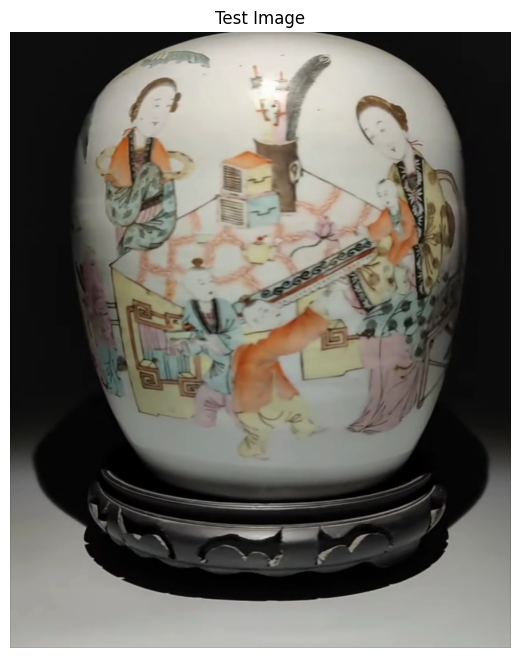

Training set: (1, 1080, 878, 3) images
Test image: torch.Size([1080, 878, 3])


In [32]:
# Load data
data = np.load('nerf_dataset/nerf_dataset.npz')
images = data['images'].astype(np.float32)
poses = data['poses'].astype(np.float32)
focal = data['focal'].astype(np.float32)  # Convert focal to float32
H, W = images.shape[1:3]
print(images.shape, poses.shape, focal)

# Check if MPS is available
device = "cuda" if torch.cuda.is_available() else "cpu"
if torch.backends.mps.is_available():
    device = "mps"
    
# Split into training and test sets
# Use the last image as test image
test_idx = -1  # Use the last image as the test image
testimg = images[test_idx]
testpose = poses[test_idx]

# Use all other images for training (excluding the test image)
if test_idx == -1:
    train_images = images[:-1]
    train_poses = poses[:-1]
else:
    # If using a specific index
    train_images = np.concatenate([images[:test_idx], images[test_idx+1:]], axis=0)
    train_poses = np.concatenate([poses[:test_idx], poses[test_idx+1:]], axis=0)

# Ensure images have 3 channels (RGB)
if train_images.shape[-1] > 3:
    print(f"Original image shape: {train_images.shape}, trimming to 3 channels")
    train_images = train_images[...,:3]
    testimg = testimg[...,:3]

# Display test image
plt.figure(figsize=(8, 8))
plt.imshow(testimg)
plt.title("Test Image")
plt.axis('off')
plt.show()

# Convert tensors to the selected device with float32 dtype
testimg = torch.from_numpy(testimg).float().to(device)
testpose = torch.from_numpy(testpose).float().to(device)

# Now use train_images and train_poses in your training loop
print(f"Training set: {train_images.shape} images")
print(f"Test image: {testimg.shape}")

## Train

Using device: mps
Iteration: 0, Loss: 0.090482, Time: 0.00 secs per iter


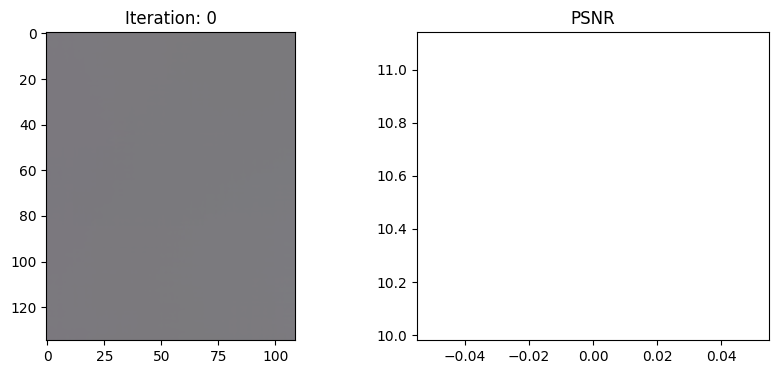

Iteration: 50, Loss: 0.040510, Time: 0.16 secs per iter


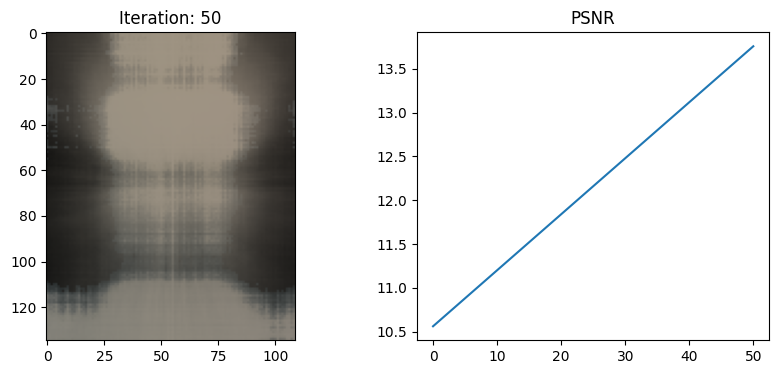

Iteration: 100, Loss: 0.019974, Time: 0.15 secs per iter


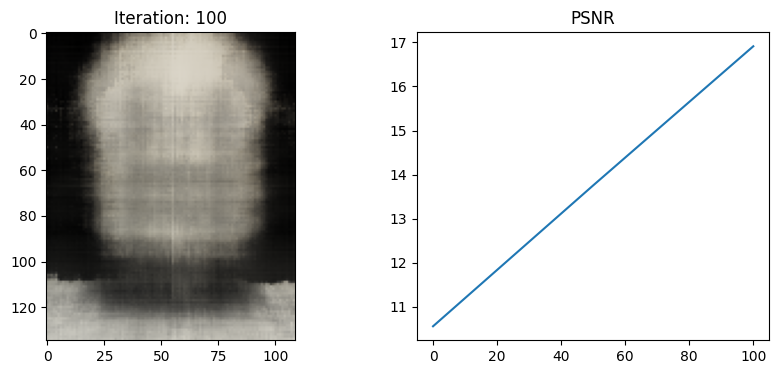

Iteration: 150, Loss: 0.010929, Time: 0.16 secs per iter


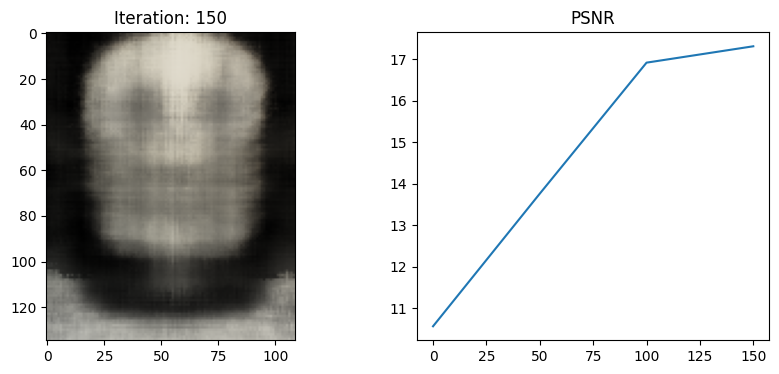

Iteration: 200, Loss: 0.010485, Time: 0.15 secs per iter


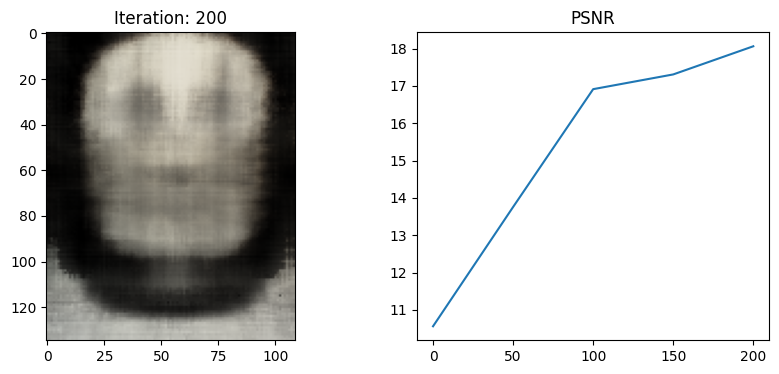

Iteration: 250, Loss: 0.009313, Time: 0.16 secs per iter


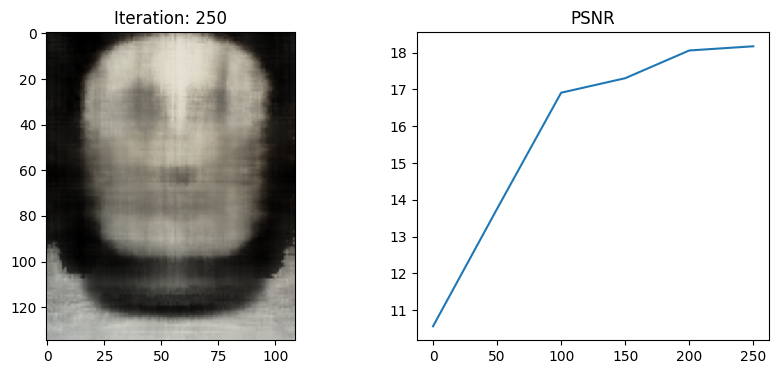

Iteration: 300, Loss: 0.008410, Time: 0.15 secs per iter


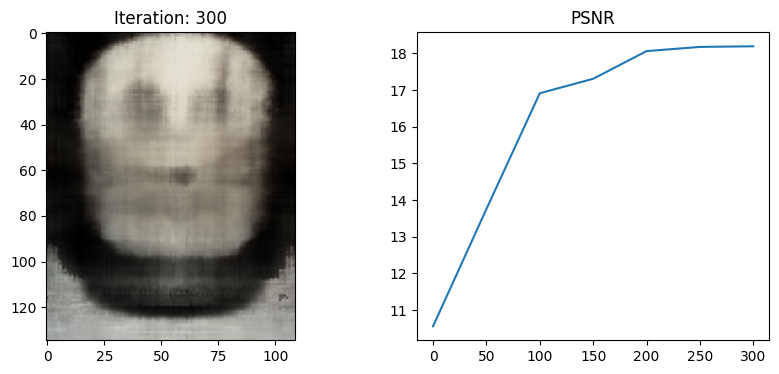

Iteration: 350, Loss: 0.007725, Time: 0.16 secs per iter


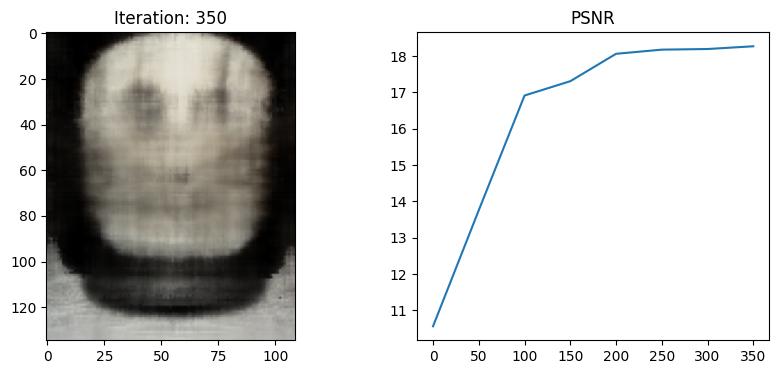

Iteration: 400, Loss: 0.008796, Time: 0.15 secs per iter


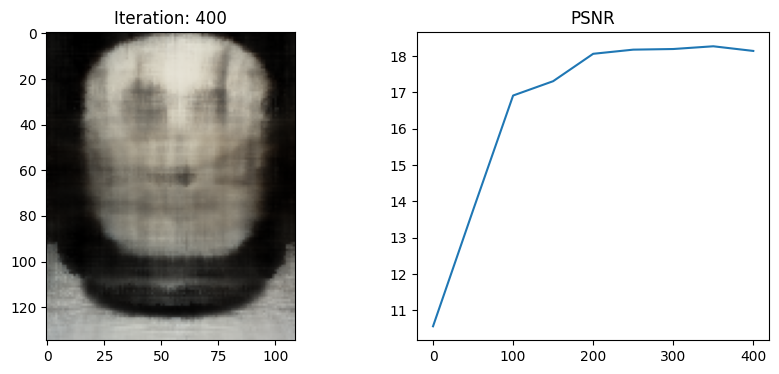

Iteration: 450, Loss: 0.007670, Time: 0.15 secs per iter


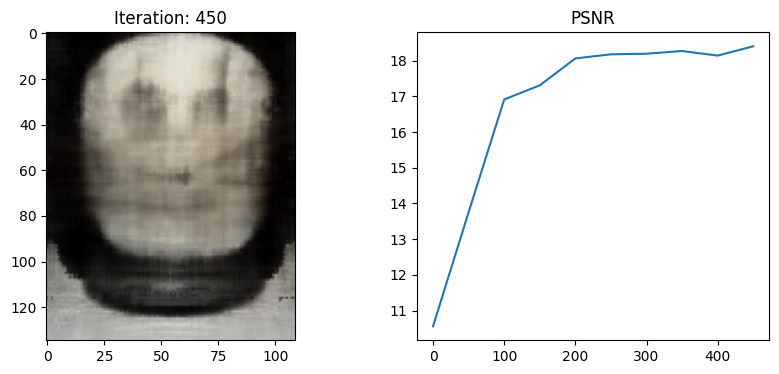

Iteration: 500, Loss: 0.006743, Time: 0.15 secs per iter


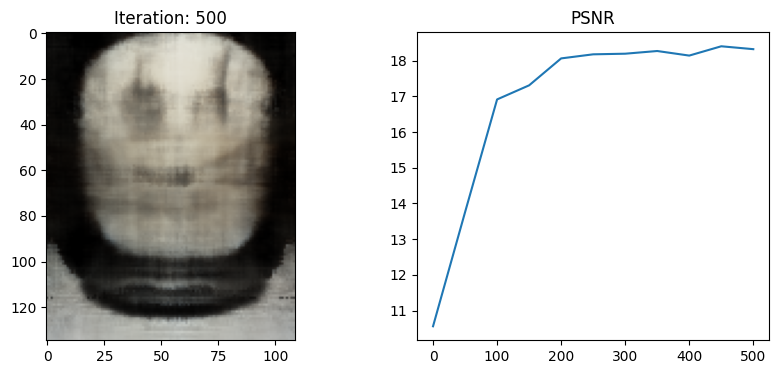

Iteration: 550, Loss: 0.007183, Time: 0.15 secs per iter


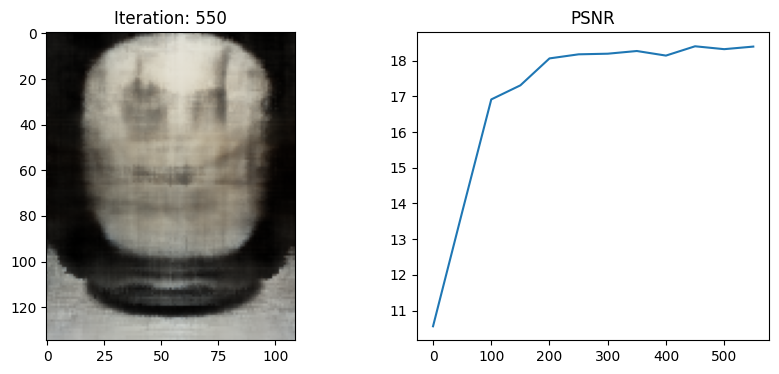

Iteration: 600, Loss: 0.004962, Time: 0.15 secs per iter


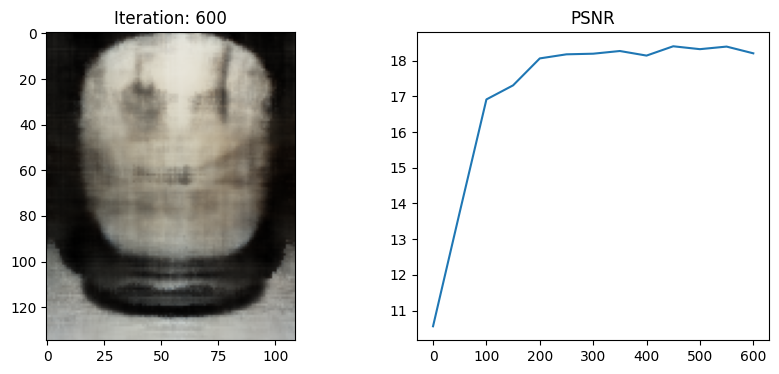

Iteration: 650, Loss: 0.005848, Time: 0.15 secs per iter


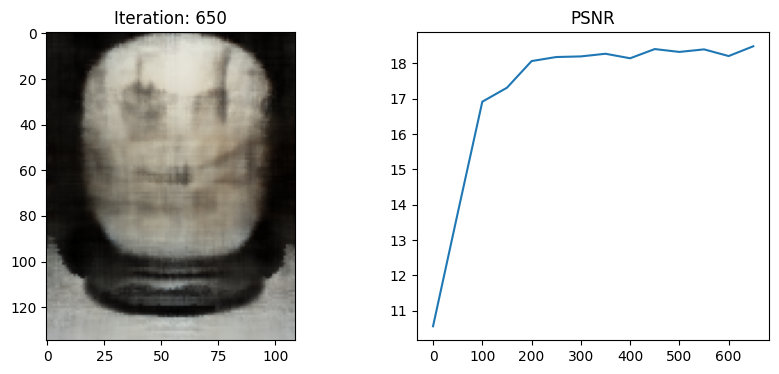

Iteration: 700, Loss: 0.005315, Time: 0.15 secs per iter


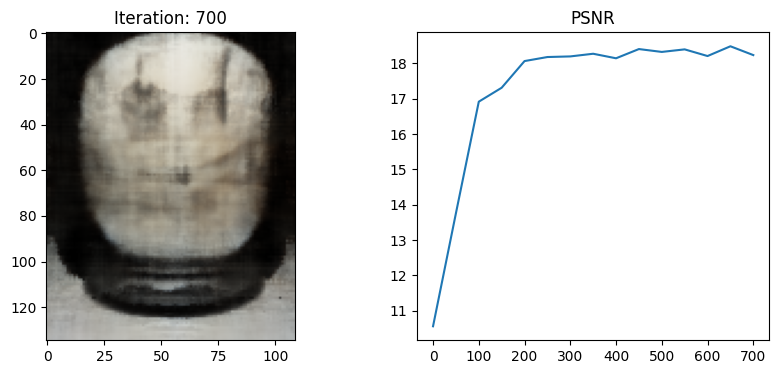

Iteration: 750, Loss: 0.004782, Time: 0.15 secs per iter


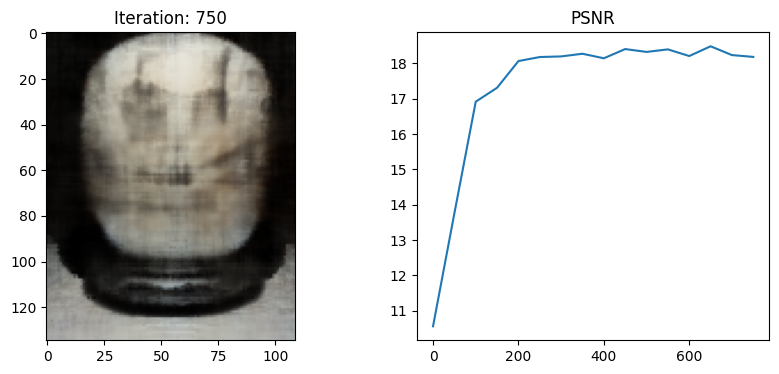

Iteration: 800, Loss: 0.005219, Time: 0.15 secs per iter


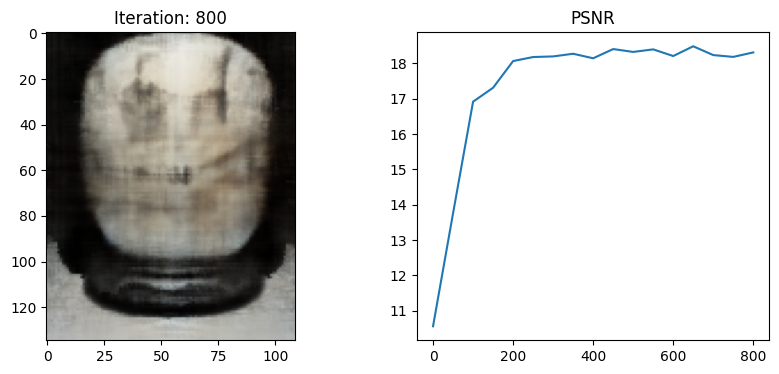

Iteration: 850, Loss: 0.004263, Time: 0.15 secs per iter


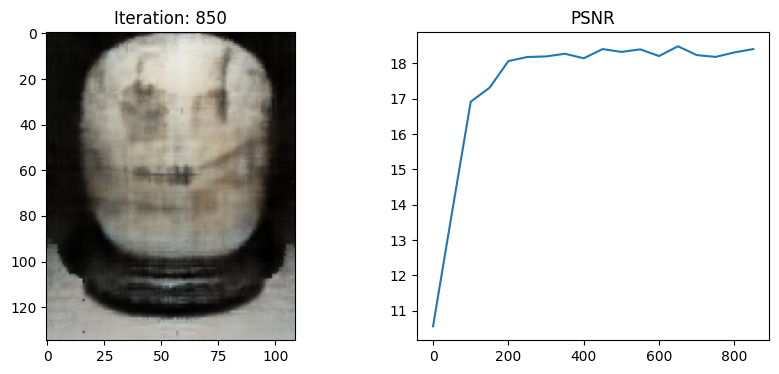

Iteration: 900, Loss: 0.004912, Time: 0.15 secs per iter


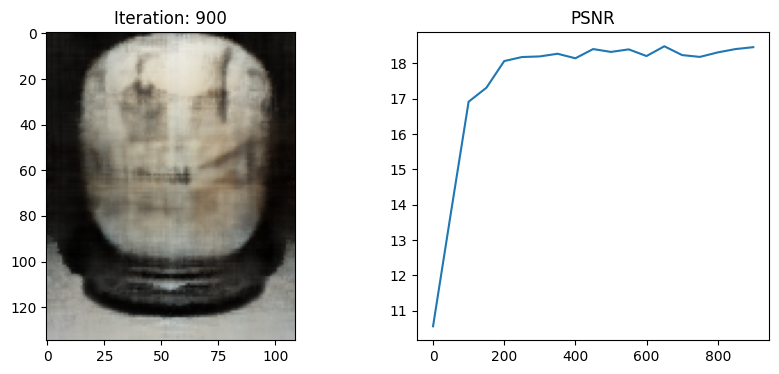

Iteration: 950, Loss: 0.003987, Time: 0.15 secs per iter


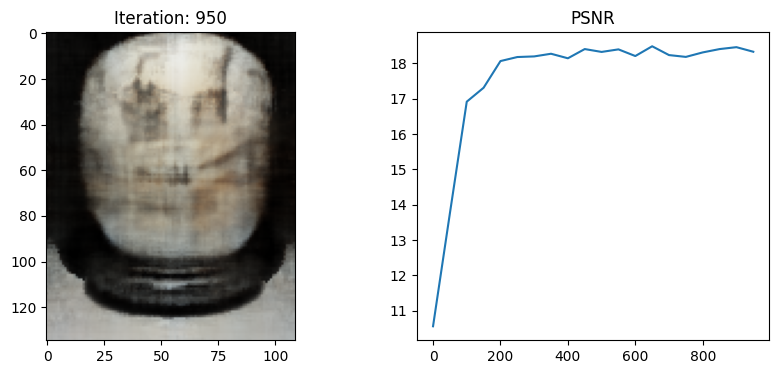

In [33]:
model = train(train_images, train_poses, H, W, focal, testpose, testimg, device)

## Render Video

In [38]:
# Transformation matrices in PyTorch
trans_t = lambda t: torch.tensor([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, t],
    [0, 0, 0, 1]
], dtype=torch.float32, device=device)

rot_phi = lambda phi: torch.tensor([
    [1, 0, 0, 0],
    [0, torch.cos(phi), -torch.sin(phi), 0],
    [0, torch.sin(phi), torch.cos(phi), 0],
    [0, 0, 0, 1]
], dtype=torch.float32, device=device)

rot_theta = lambda th: torch.tensor([
    [torch.cos(th), 0, -torch.sin(th), 0],
    [0, 1, 0, 0],
    [torch.sin(th), 0, torch.cos(th), 0],
    [0, 0, 0, 1]
], dtype=torch.float32, device=device)

# Pose function with spherical coordinates
def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = torch.matmul(rot_phi(torch.tensor([phi / 180. * np.pi], dtype=torch.float32, device=device)), c2w)
    c2w = torch.matmul(rot_theta(torch.tensor([theta / 180. * np.pi], dtype=torch.float32, device=device)), c2w)
    c2w = torch.tensor([[-1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]],
                      dtype=torch.float32, device=device) @ c2w
    return c2w

# Enhanced rendering function with debug information
def f_optimized(**kwargs):
    # Extract parameters and convert float sliders to appropriate types
    near = float(kwargs.pop('near', 2.))
    far = float(kwargs.pop('far', 6.))
    n_samples = int(kwargs.pop('n_samples', 32))
    downscale = int(kwargs.pop('downscale', 4))
    
    # Get camera pose
    c2w = pose_spherical(**kwargs)
    
    # Print debug info
    print(f"Camera position: {c2w[0,3].item():.2f}, {c2w[1,3].item():.2f}, {c2w[2,3].item():.2f}")
    print(f"Rendering with: near={near}, far={far}, samples={n_samples}, downscale={downscale}")
    
    # Use a lower resolution for interactive visualization
    h, w = H // downscale, W // downscale
    
    # Get rays with downsampling
    rays_o, rays_d = get_rays(h, w, focal / downscale, c2w[:3, :4])
    c2w, rays_o, rays_d = map(lambda t: t.to(device), (c2w, rays_o, rays_d))
    
    # Process rays in batches to save memory
    ray_batch_size = 8192
    total_rays = rays_o.shape[0]
    rgb_parts = []
    
    with torch.no_grad():
        for i in range(0, total_rays, ray_batch_size):
            # Get ray batch
            end_idx = min(i + ray_batch_size, total_rays)
            batch_rays_o = rays_o[i:end_idx]
            batch_rays_d = rays_d[i:end_idx]
            
            # Render with specified parameters
            rgb_batch, _, _ = render_rays(
                model, 
                batch_rays_o, 
                batch_rays_d, 
                near=near,
                far=far,
                N_samples=n_samples,
                device=device, 
                chunk=64
            )
            
            # Move results to CPU immediately
            rgb_parts.append(rgb_batch.cpu())
            
            # Clean up batch
            del batch_rays_o, batch_rays_d, rgb_batch
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            import gc
            gc.collect()
        
        # Combine batches on CPU
        rgb = torch.cat(rgb_parts, dim=0)
        rgb = rgb.reshape(h, w, 3)
        
        # Clamp and convert to numpy
        img = torch.clamp(rgb, 0, 1).numpy()
        
        # Display at a reasonable size
        plt.figure(figsize=(12, 12 * h / w))
        plt.imshow(img)
        plt.title(f"θ={kwargs['theta']:.1f}°, φ={kwargs['phi']:.1f}°, r={kwargs['radius']:.1f}")
        plt.axis('off')
        plt.show()
        
        # Clean up
        del rgb, rgb_parts
        gc.collect()

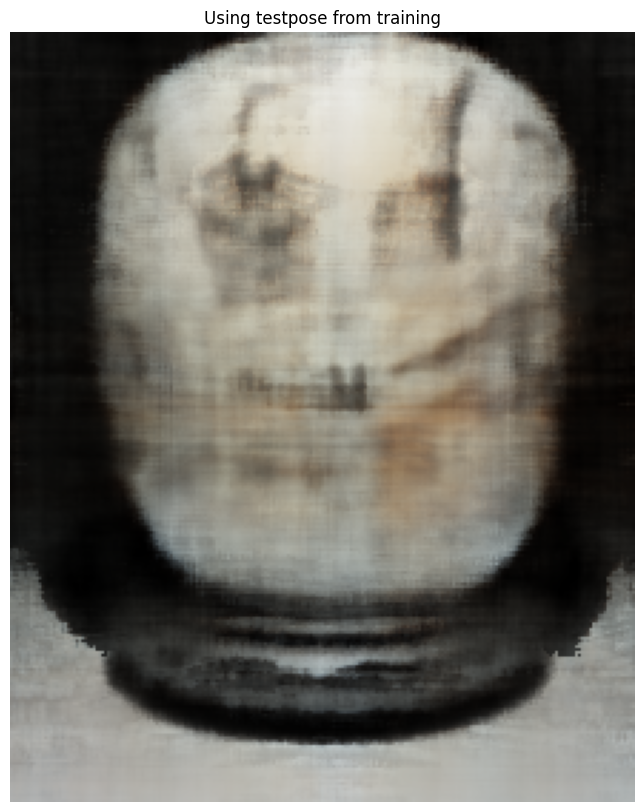

In [40]:
import gc  # Add this at the top with your other imports

# Try rendering with the test pose that was used during training
def render_with_testpose():
    with torch.no_grad():
        downscale = 4  # Lower resolution for quick viewing
        h, w = H // downscale, W // downscale
        
        # Get rays from the testpose
        rays_o, rays_d = get_rays(h, w, focal / downscale, testpose[:3, :4])
        rays_o, rays_d = rays_o.to(device), rays_d.to(device)
        
        # Process in batches
        ray_batch_size = 8192
        total_rays = rays_o.shape[0]
        rgb_parts = []
        
        for i in range(0, total_rays, ray_batch_size):
            end_idx = min(i + ray_batch_size, total_rays)
            batch_o = rays_o[i:end_idx]
            batch_d = rays_d[i:end_idx]
            
            rgb_batch, _, _ = render_rays(
                model, batch_o, batch_d, near=2., far=6.,
                N_samples=32, device=device, chunk=64
            )
            
            rgb_parts.append(rgb_batch.cpu())
            del batch_o, batch_d, rgb_batch
            gc.collect()
        
        # Combine and reshape
        rgb = torch.cat(rgb_parts, dim=0).reshape(h, w, 3)
        
        # Display
        img = torch.clamp(rgb, 0, 1).numpy()
        plt.figure(figsize=(10, 10))
        plt.imshow(img)
        plt.title("Using testpose from training")
        plt.axis('off')
        plt.show()
        
        # Clean up
        del rgb, rgb_parts
        gc.collect()

# Call this function to see the result
render_with_testpose()

In [ ]:
import gc
import torch
import matplotlib.pyplot as plt
from ipywidgets import interactive, widgets

# Simplified interactive viewer with hardcoded defaults
def render_view(theta, phi, radius, near, far, n_samples, downscale):
    with torch.no_grad():
        # Get camera pose
        c2w = pose_spherical(theta, phi, radius)
        
        # Use a lower resolution for interactive visualization
        h, w = H // downscale, W // downscale
        
        # Get rays with downsampling
        rays_o, rays_d = get_rays(h, w, focal / downscale, c2w[:3, :4])
        rays_o, rays_d = rays_o.to(device), rays_d.to(device)
        
        # Process rays in batches to save memory
        ray_batch_size = 8192
        total_rays = rays_o.shape[0]
        rgb_parts = []
        
        for i in range(0, total_rays, ray_batch_size):
            # Get ray batch
            end_idx = min(i + ray_batch_size, total_rays)
            batch_o = rays_o[i:end_idx]
            batch_d = rays_d[i:end_idx]
            
            # Render with specified parameters
            rgb_batch, _, _ = render_rays(
                model, 
                batch_o, 
                batch_d, 
                near=near,
                far=far,
                N_samples=int(n_samples),
                device=device, 
                chunk=64
            )
            
            # Move results to CPU immediately
            rgb_parts.append(rgb_batch.cpu())
            
            # Clean up batch
            del batch_o, batch_d, rgb_batch
            gc.collect()
        
        # Combine batches on CPU
        rgb = torch.cat(rgb_parts, dim=0)
        rgb = rgb.reshape(h, w, 3)
        
        # Clamp and convert to numpy
        img = torch.clamp(rgb, 0, 1).numpy()
        
        # Display at a reasonable size
        plt.figure(figsize=(12, 12 * h / w))
        plt.imshow(img)
        plt.title(f"θ={theta:.1f}°, φ={phi:.1f}°, r={radius:.1f}, near={near}, far={far}")
        plt.axis('off')
        plt.show()
        
        # Clean up
        del rgb, rgb_parts
        gc.collect()

# Create a simpler interactive viewer with hardcoded values
interactive_widget = interactive(
    render_view,
    theta=widgets.FloatSlider(value=100.0, min=0.0, max=360.0, step=5.0, description='Theta'),
    phi=widgets.FloatSlider(value=-30.0, min=-90.0, max=0.0, step=5.0, description='Phi'),
    radius=widgets.FloatSlider(value=6.0, min=2.0, max=12.0, step=0.5, description='Radius'),
    near=widgets.FloatSlider(value=1.0, min=0.1, max=5.0, step=0.1, description='Near'),
    far=widgets.FloatSlider(value=10.0, min=3.0, max=20.0, step=1.0, description='Far'),
    n_samples=widgets.IntSlider(value=32, min=16, max=64, step=8, description='Samples'),
    downscale=widgets.IntSlider(value=4, min=2, max=8, step=1, description='Downscale')
)

# Display the widget
display(interactive_widget)

interactive(children=(FloatSlider(value=100.0, description='Theta', max=360.0, step=5.0), FloatSlider(value=-3…

In [45]:
frames = []
for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):
    c2w = pose_spherical(th, -30., 4.)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    c2w, rays_o, rays_d = map(lambda t: t.to(device), (c2w, rays_o, rays_d))
    with torch.no_grad():
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=32, device=device)
        rgb = rgb.reshape(H, W, 3)
        frames.append((255*np.clip(rgb.cpu().detach().numpy(),0,1)).astype(np.uint8))

import imageio
f = 'video.mp4'
imageio.mimwrite(f, frames, fps=30, quality=7)

 15%|█▌        | 18/120 [17:10<1:37:17, 57.23s/it]


KeyboardInterrupt: 

In [47]:
import imageio
f = 'video.gif'
imageio.mimwrite(f, frames, fps=30)

In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)